In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from utils import fpath2points

### Getting the data 

In [3]:
root_dir = Path("data/training")
all_img_paths = get_image_files(root_dir)
data = pd.read_csv("data/training_frames_keypoints.csv")

In [4]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


(303, 288)


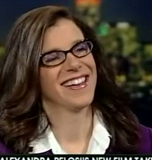

In [5]:
im = PILImage.create(all_img_paths[62])
print(im.shape)
im.to_thumb(160)

In [6]:
# as the model kinda memorized where the points are
# and just draw them in the model of the image
# we will use data augs 
item_tfms = [Resize(224, method='squish')]
batch_tfms= [Flip(), Rotate(), Zoom(), Warp()]

In [7]:
faces = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=fpath2points,
                 splitter=RandomSplitter(seed=42),
                 item_tfms = item_tfms,
                 batch_tfms=batch_tfms)

In [8]:
faces.summary('data/training/')

Setting-up type transforms pipelines
Found 3462 items
2 datasets of sizes 2770,692
Setting up Pipeline: PILBase.create
Setting up Pipeline: fpath2points -> TensorPoint.create

Building one sample
  Pipeline: PILBase.create
    starting from
      data/training/Andrea_Bocelli_21.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=249x264
  Pipeline: fpath2points -> TensorPoint.create
    starting from
      data/training/Andrea_Bocelli_21.jpg
    applying fpath2points gives
      Tensor of size 68x2
    applying TensorPoint.create gives
      TensorPoint of size 68x2

Final sample: (PILImage mode=RGB size=249x264, TensorPoint([[ 53., 104.],
             [ 53., 122.],
             [ 53., 137.],
             [ 53., 152.],
             [ 60., 167.],
             [ 71., 185.],
             [ 86., 196.],
             [100., 208.],
             [119., 215.],
             [130., 212.],
             [133., 208.],
             [137., 201.],
             [144., 186.],
             

In [9]:
dls = faces.dataloaders('data/training/', bs=32)

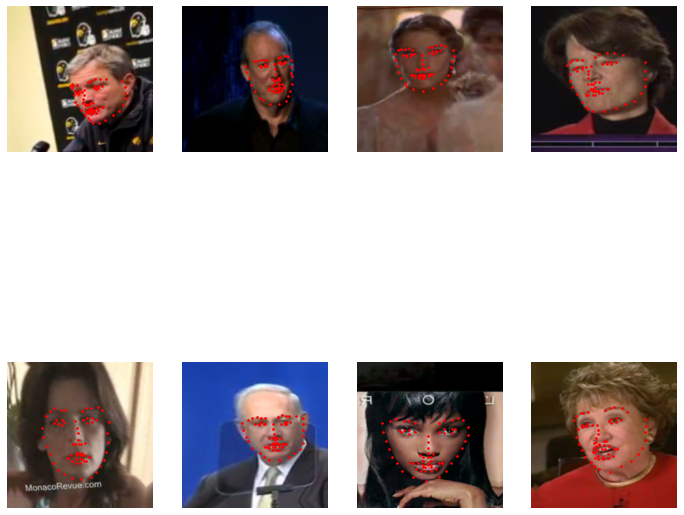

In [48]:
dls.train.show_batch(max_n=8, figsize=(12, 12))

In [12]:
dls.c = dls.train.after_item.c

In [13]:
dls.c

136

### Learner and model 

In [54]:
learn = vision_learner(dls, resnet18)

/home/kelwa/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kelwa/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0020892962347716093)

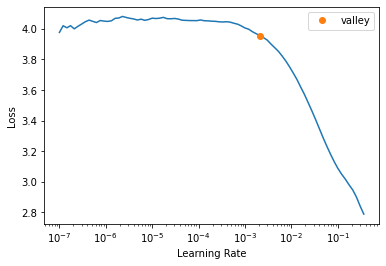

In [55]:
learn.lr_find()

In [39]:
1e-3

0.001

In [56]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,time
0,2.559255,0.461017,01:47
1,0.851770,0.088534,01:49
2,0.278846,0.045336,01:49
3,0.118677,0.038337,01:48
4,0.077207,0.036646,01:53


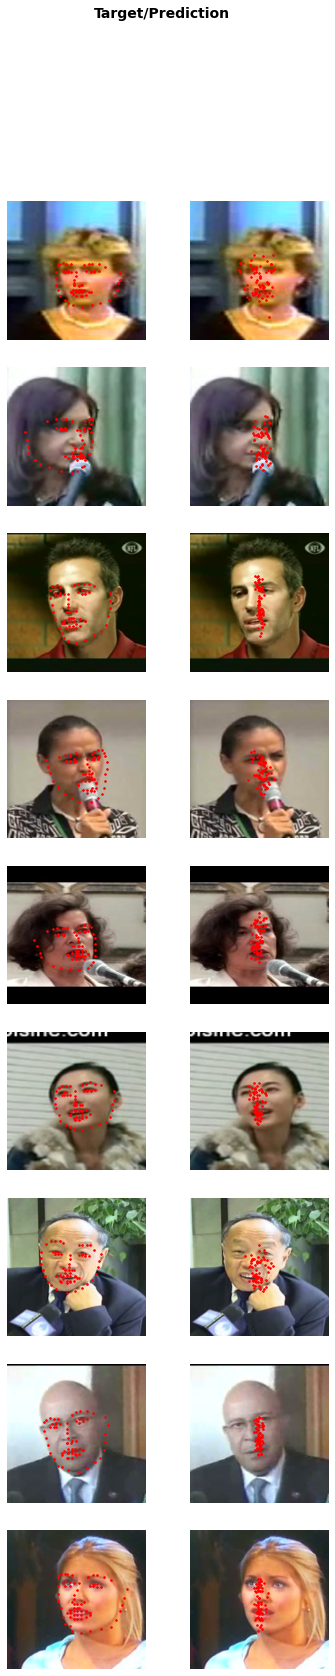

In [57]:
learn.show_results()

SuggestedLRs(valley=0.0002754228771664202)

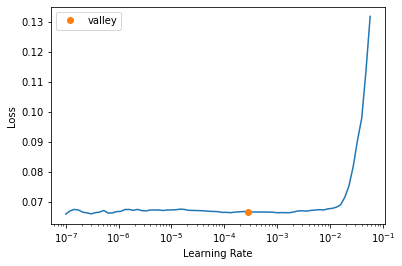

In [58]:
learn.unfreeze()
learn.lr_find()

In [61]:
2e-4

0.0002

In [62]:
learn.fit_flat_cos(50, 3e-4)

epoch,train_loss,valid_loss,time
0,0.055301,0.031385,01:32
1,0.042539,0.022342,01:30
2,0.034062,0.018136,01:30
3,0.028257,0.017834,01:30
4,0.025216,0.023440,01:30
5,0.021038,0.015929,01:31
6,0.018417,0.012325,01:30
7,0.015632,0.006462,01:31
8,0.013875,0.018001,01:31
9,0.012887,0.010772,01:31


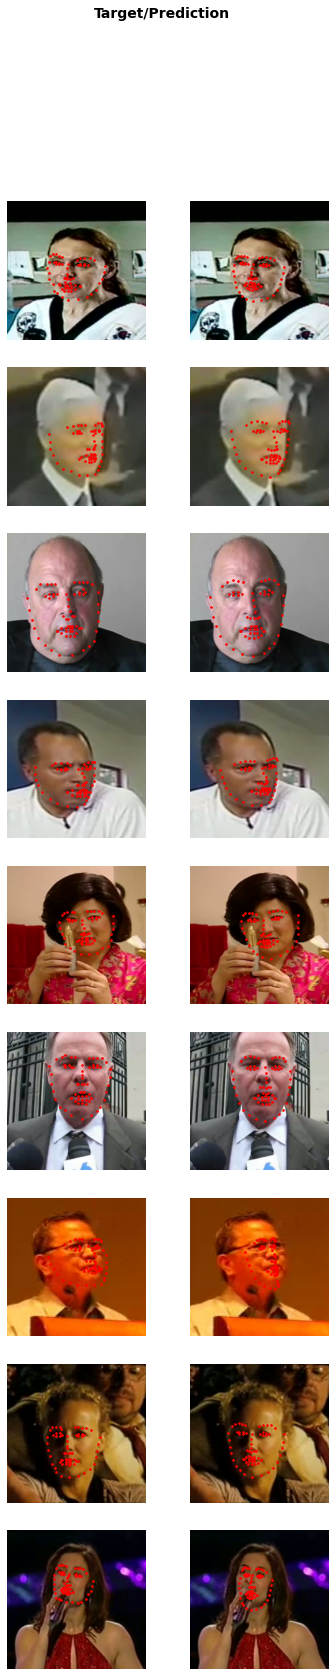

In [63]:
learn.show_results()

In [64]:
learn.save('04.pth')

Path('models/04.pth.pth')

In [75]:
img_path = 'data/test_imgs/full.jpg'

In [76]:
outputs = learn.predict(img_path)

In [77]:
from utils import load_img

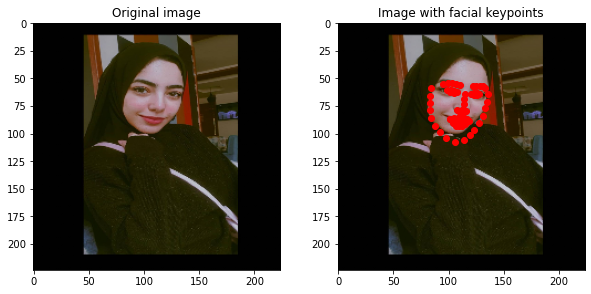

In [78]:
# ix = 3
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
# im = test_dataset.load_img(ix)
img = load_img(img_path)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(img)
plt.scatter(outputs[0][:, 0], outputs[0][:, 1], c='r')
plt.grid(False)
plt.show()